# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

## Inspecting the data

In this first code block, we will explore the dataset by examining its dimensionality and distribution. The training set is made up of **25,500 samples**, each with **24 attributes** that capture a wide array of data points relevant to the problem. This dimensionality provides a thorough representation of the features. Looking at the output, we find that there are **2 unique target classes**, indicating a binary classification problem. The label distribution reveals a notable class imbalance: **19,815 samples** belong to class **0**, while only **5,685 samples** are in class **1**. Recognizing this disparity is extremely important, as it can impact model performance, particularly regarding accuracy and recall metrics. To address such imbalances, techniques that consider the uneven distribution of classes may be required.

The dataset has no missing values across all features, so data absence will not hinder our analysis. This preliminary analysis also indicates that the numerical features vary significantly. For instance, the `LIMIT_BAL` feature ranges from **10,000 to 1,000,000**, while `PAY_AMT1` ranges from **0 to 1,684,259**. This variation suggests the need for normalization or standardization during preprocessing to prevent any single feature from disproportionately influencing the model due to its scale.

Examining the first few samples of the training set provides insights into the data's underlying structure. For example, some features contain negative values, particularly the payment history features. Understanding the implications of these values is important for interpreting the dataset and training the model effectively. These features may indicate insolvencies, which are important for predicting defaults.

In [29]:
# Import necessary libraries
import pandas as pd  
import numpy as np  
import os 

# Set environment variable to suppress TensorFlow logging warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def load_data(path, train=True):
    """
    Load and preprocess data from a specified CSV file.

    Parameters:
    path (str): The path to the CSV file to be loaded.
    train (bool): A flag indicating whether to load training data or test data.
                  If True, the data will be shuffled and returned without the last column (target variable).
                  If False, the first column will be treated as labels, and the rest as features.

    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing:
        - A NumPy array of features.
        - A NumPy array of labels (if train is True) or a NumPy array of IDs (if train is False).
    """
    # Load data from the specified CSV file with the given encoding
    df = pd.read_csv(path, encoding="ISO-8859-2")

    if train:
        # Shuffle the data and return features and labels for training
        data = df.sample(frac=1, random_state=42).values
        return data[:, :-1].astype(np.float32), data[:, -1]

    # Return features and IDs for test data
    return df.iloc[:, 1:].values.astype(np.float32), df.iloc[:, 0].astype(str)

# Load training and testing data
X_train, labels = load_data('./train.csv')  # Load training data
X_test, ids = load_data('./test.csv', train=False)  # Load test data

# Display the dimensions of the training set and the count of features
print(f"\nTraining set dimensions: {X_train.shape}\nFeatures count: {X_train.shape[1]}")

# Count the number of unique classes in the labels
num_classes = len(np.unique(labels))
print(f"Number of target classes: {num_classes}")

# Display the first five samples of the training set
print("\nFirst 5 training samples:\n", pd.DataFrame(X_train).head())

# Display the distribution of the labels in the training set
print("\nLabels distribution:\n", pd.Series(labels).value_counts())

# Load the training data again for analysis
train_data = pd.read_csv('./train.csv')

# Display the count of missing values for each column in the training data
print("\nMissing values:\n", train_data.isnull().sum())

# Display summary statistics for the training data
print("\nSummary statistics:\n", train_data.describe())

# Display the dimensions of the test set
print("\nTest set dimensions:", X_test.shape)

# Display the actual training set data and corresponding labels
print("\nTraining set data:\n", X_train)
print("\nTraining set labels:\n", labels)


Training set dimensions: (25500, 24)
Features count: 24
Number of target classes: 2

First 5 training samples:
         0         1    2    3    4     5    6    7    8    9   ...       14  \
0  21870.0   70000.0  2.0  3.0  2.0  26.0  0.0  0.0  0.0  0.0  ...   8948.0   
1  15211.0  320000.0  2.0  2.0  2.0  28.0 -1.0 -1.0 -1.0 -1.0  ...    944.0   
2  20041.0   30000.0  2.0  2.0  2.0  36.0  0.0 -1.0 -1.0  0.0  ...  30452.0   
3   9190.0   20000.0  2.0  3.0  1.0  35.0  0.0  0.0  2.0  2.0  ...  18621.0   
4   6260.0   80000.0  1.0  2.0  2.0  32.0  1.0  2.0  0.0  0.0  ...  28242.0   

        15       16       17      18       19      20      21      22      23  
0   9006.0  10570.0  11421.0  2000.0   1200.0  1500.0  2000.0  1000.0  2000.0  
1    473.0   1747.0   1193.0   390.0    944.0   473.0  5000.0  1200.0   980.0  
2  29667.0  28596.0  29180.0   490.0  33299.0  1400.0   572.0   584.0   400.0  
3  18024.0  18434.0  19826.0  3000.0   1000.0     0.0   700.0  1700.0     0.0  
4  21400.0  

## Preparing the data

In this second code cell, we detail the pre-processing steps taken to prepare the dataset for model training. Based on insights gained from the initial data inspection, several decisions were made to ensure an effective analysis. The first step was to extract the relevant features and labels from the raw training dataset. We isolated the label column, `default payment next month`, for use in model training. The `ID` column was deemed unnecessary for predictive modeling, as it does not contribute in understanding the features that influence the outcome. As a consequence, it was dropped from the feature matrix to streamline the dataset. Next, we needed to address the varying scales of the features. The variance plot revealed that some features had significantly higher variances than others. This could skew the model's performance, as features with larger scales might dominate the learning process. To counter this, **StandardScaler** was used, which standardizes features by removing the mean and scaling to unit variance. This process ensures that each feature contributes equally to the analysis.
 
The dataset was then split into training and validation sets using a stratified approach. This method preserves the original class distribution in both subsets, which is especially important due to the class imbalance identified earlier. The training set consists of **15,300 samples**, while the validation set includes **10,200 samples**. This balanced strategy minimizes the risk of overfitting and improves the reliability of model evaluation. After the data split, we applied **StandardScaler** to the training set, generating scaled feature values. The same scaler was applied to the validation set to ensure consistency in data transformation. This step is important for maintaining the same data distribution during both training and validation phases, thus enhancing the generalization of learned patterns.


In [1]:
import pandas as pd  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 

def preprocess_data(X, scaler=None):
    """
    Preprocesses the input data by scaling the features using StandardScaler.
    
    Parameters:
    X (pd.DataFrame or np.array): Feature data to be scaled.
    scaler (StandardScaler, optional): Pre-fitted scaler object. If None, a new scaler will be fitted to the data.
    
    Returns:
    tuple:
        - Scaled feature matrix (np.array)
        - Fitted scaler (StandardScaler object)
    
    The function either uses an existing scaler to transform the data or fits a new one if none is provided.
    """
    # If no scaler is provided, fit a new StandardScaler to the data
    if scaler is None:
        scaler = StandardScaler().fit(X)
    
    # Transform the data using the fitted scaler
    return scaler.transform(X), scaler

# Load the training dataset
df_train = pd.read_csv('./train.csv')

# Extract the label column ('default payment next month') from the dataset
labels_raw = df_train['default payment next month']

# Specify columns to be dropped from the feature matrix (e.g., 'ID' and the label column)
columns_to_drop = ["ID"]

# Drop the specified columns and the label from the training dataset to create the feature matrix
X_train_raw = df_train.drop(columns=columns_to_drop + ['default payment next month'])

# Split the dataset into training and validation sets (60% train, 40% validation)
# Stratify ensures that the class distribution is maintained in both train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, labels_raw, 
                                                  test_size=0.4, random_state=42, stratify=labels_raw)

# Scale the training data using StandardScaler
X_train_scaled, scaler = preprocess_data(X_train)

# Use the same scaler to scale the validation data
X_val_scaled, _ = preprocess_data(X_val, scaler)

# Output the shapes of the scaled training and validation datasets as well as their corresponding label sets
print(f"Shapes -> Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, "
      f"Encoded Train: {y_train.shape}, Encoded Val: {y_val.shape}")

Shapes -> Train: (15300, 23), Val: (10200, 23), Encoded Train: (15300,), Encoded Val: (10200,)


## Building the network

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

In [19]:
from keras.optimizers import Adam
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score
from keras.layers import Input
from keras.regularizers import l2

def build_model(input_shape):
    """
    Builds an improved fully connected neural network model with better regularization
    and more stable training characteristics.
    
    Parameters:
    input_shape (int): The number of input features
    
    Returns:
    model (Sequential): A compiled Keras model ready for training
    """
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(input_shape,)))
    
    # First hidden layer - reduced size, increased regularization
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(0.3))  # Reduced dropout rate for more stability
    
    # Second hidden layer
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(0.3))
    
    # Third hidden layer - smaller for better generalization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(0.2))  # Even lower dropout in final layers
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Use a lower learning rate and higher momentum for stability
    optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
    
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# Build the model with the input shape
input_shape = X_train_scaled.shape[1]
model = build_model(input_shape)

# Adjusted hyperparameters for more stable training
batch_size = 128  # Increased batch size for more stable gradients
epochs = 69       # Increased epochs but with better early stopping

# Display model summary
model.summary()

# Improved EarlyStopping with more patience and better monitoring
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    min_delta=0.001  # Minimum change to qualify as an improvement
)

# Modified ReduceLROnPlateau for smoother learning rate adjustment
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Smaller reduction factor
    patience=10,
    min_lr=1e-6,
    min_delta=0.001
)

# Print input and output shape
dims = X_train_scaled.shape[1]
print('Input Shape: ', dims)

nb_classes = y_train.shape[1] if len(y_train.shape) > 1 else 1
print('Output Shape: ', nb_classes)

# Train the model with improved parameters and monitoring
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr, ProgressBar(rolling_window=5)],
    verbose=0,
    shuffle=True,  # Ensure good shuffling of training data
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

# Display results
print("\n\nRESULTS:")
print(f"{'Validation Loss:':<20} {val_loss:.4f}")
print(f"{'Validation Accuracy:':<20} {val_accuracy:.4f}")

# Calculate F1 score
y_pred_prob = model.predict(X_val_scaled, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)
f1 = f1_score(y_val, y_pred)
print(f"{'F1 Score:':<20} {f1:.4f}")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,153 (192.00 KB)

 Trainable params: 48,257 (188.50 KB)

 Non-trainable params: 896 (3.50 KB)

Input Shape:  23
Output Shape:  1
Epoch 58/69 - accuracy: 0.8243 - loss: 0.4238 - val_accuracy: 0.8182 - val_loss: 0.4496 - learning_rate: 0.0000

RESULTS:
Validation Loss:     0.4474
Validation Accuracy: 0.8186
F1 Score:            0.4684


## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results  

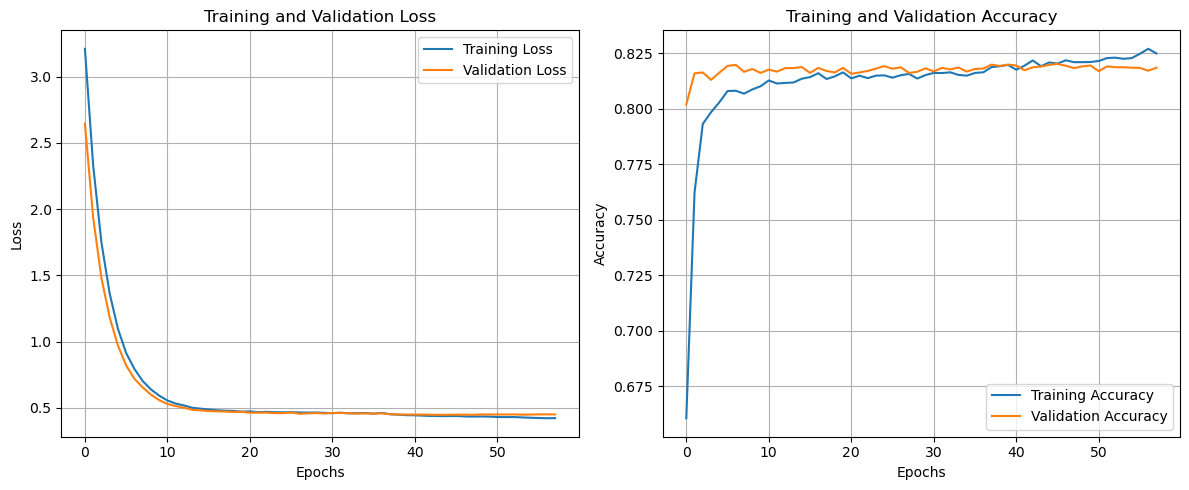

Final Training Loss: 0.4223
Final Validation Loss: 0.4502
Final Training Accuracy: 0.8248
Final Validation Accuracy: 0.8184
The model performs better on the training set compared to the validation set, which might indicate overfitting.


In [20]:
import matplotlib.pyplot as plt 

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over epochs.
    
    Parameters:
    history: History object returned from model.fit() that contains training and validation metrics for each epoch.
    
    The function generates two subplots: one for loss and one for accuracy, for both the training and validation sets.
    """
    plt.figure(figsize=(12, 5))  # Set the size of the plot figure

    # Plot training and validation loss
    plt.subplot(1, 2, 1)  # Create a subplot for loss (1 row, 2 columns, 1st plot)
    plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
    plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
    plt.title('Training and Validation Loss')  # Set the title of the plot
    plt.xlabel('Epochs')  # Label x-axis as 'Epochs'
    plt.ylabel('Loss')  # Label y-axis as 'Loss'
    plt.legend()  # Add a legend to differentiate between training and validation
    plt.grid()  # Add a grid for better readability

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy (1 row, 2 columns, 2nd plot)
    plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
    plt.title('Training and Validation Accuracy')  # Set the title of the plot
    plt.xlabel('Epochs')  # Label x-axis as 'Epochs'
    plt.ylabel('Accuracy')  # Label y-axis as 'Accuracy'
    plt.legend()  # Add a legend to differentiate between training and validation
    plt.grid()  # Add a grid for better readability

    plt.tight_layout()  # Adjust the layout to prevent overlap between subplots
    plt.show()  # Display the plots

# Call the function to plot training history
plot_training_history(history)

# Extract the final training and validation loss and accuracy from the history object
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print final metrics for training and validation
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# Compare training and validation performance and interpret the results
if final_train_loss < final_val_loss:
    print("The model performs better on the training set compared to the validation set, which might indicate overfitting.")
elif final_train_loss > final_val_loss:
    print("The model performs better on the validation set compared to the training set, indicating potential underfitting.")
else:
    print("The model performs similarly on both sets, suggesting a good fit.")

## Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Predict the probabilities for the validation set
y_val_pred_prob = model.predict(X_val_scaled)

# Convert predicted probabilities to binary predictions using a threshold of 0.5
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Generate the confusion matrix to compare actual vs predicted values
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(confusion)

# Create a detailed classification report including precision, recall, and F1-score
class_report = classification_report(y_val, y_val_pred, target_names=["No Default", "Default"])
print("Classification Report:")
print(class_report)

# Calculate the ROC AUC score using the predicted probabilities
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[7535  391]
 [1459  815]]
Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.95      0.89      7926
     Default       0.68      0.36      0.47      2274

    accuracy                           0.82     10200
   macro avg       0.76      0.65      0.68     10200
weighted avg       0.80      0.82      0.80     10200

ROC AUC Score: 0.7782


## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

In [22]:
import pandas as pd  

# Load the test dataset from a CSV file
test_df = pd.read_csv('test.csv')

# Drop the 'ID' column if it exists, as it is not needed for predictions
if 'ID' in test_df.columns:
    test_df = test_df.drop(columns=['ID'])

# Copy the test dataset to preserve the original data structure
X_test = test_df.copy()

# Ensure that the number of features in the test set matches the expected number of features
if X_test.shape[1] == scaler.n_features_in_:
    # Standardize the test set using the same scaler fitted on the training data
    X_test_scaled = scaler.transform(X_test)
else:
    # Raise an error if the number of columns does not match the training data
    raise ValueError("Impossibile standardizzare i dati: il numero di colonne non corrisponde.")

# Predict the probabilities for the test set using the trained model
test_predictions_prob = model.predict(X_test_scaled)

# Convert predicted probabilities to binary class predictions using a threshold of 0.5
test_predictions = (test_predictions_prob > 0.5).astype(int)

# Save the predictions to a CSV file without including the header or index
pd.DataFrame(test_predictions, columns=['Predicted']).to_csv('test_predictions.csv', index=False, header=False)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [23]:
from sklearn.metrics import accuracy_score, f1_score

true_labels_df = pd.read_csv('test_with_labels_real.csv', header=None)  
true_labels = true_labels_df[0].values 

predictions_df = pd.read_csv('test_predictions.csv', header=None)
predictions = predictions_df[0].values 

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.8307
F1 Score: 0.4752


# OPTIONAL -- Export the predictions in the format indicated in the assignment release page and verify you prediction on the [assessment page](https://aml-assignmentone-2425.streamlit.app/).